In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import collections
import json
import pandas as pd
from tqdm import tqdm
from naive_bayes_sentiment_classifier import get_naive_bayes_info, naive_bayes_predict

In [2]:
all_game_df = pd.read_csv('all_game_data.csv')
all_game_df.head()

,home,away,week,home_pass,away_pass,home_rush,away_rush,home_points,away_points,home_turnover,away_turnover,home_win
0,MIN,JAX,1,184.8,136.2,144.9,123.1,21.3,15.2,-0.2,0.3,1
1,KC,ATL,1,192.5,257.4,118.3,111.6,13.3,23.8,-0.1,0.5,0
2,NYG,DAL,1,293.9,262.6,94.7,112.9,24.8,23.1,0.7,0.3,0
3,NO,WAS,1,346.7,235.8,129.5,100.9,34.7,18.0,-0.4,-0.9,0
4,OAK,SD,1,247.6,276.6,131.9,116.5,22.4,25.4,-0.3,-0.4,0


In [3]:
with open('tweet_ids_0_to_930000') as json_file:
    tweet_id_to_text = json.load(json_file)

In [4]:
tweet_id_to_text['240817713533026304']

'RT @Dock_El_S_D: @hippyhoppin Molina is the #Cardinals MVP. No doubts about that my man.'

In [5]:
log_prior, log_likelihood = get_naive_bayes_info()

0.0
9086
Naive Bayes accuracy = 0.9940


In [6]:
p = naive_bayes_predict(tweet_id_to_text['240817713533026304'], log_prior, log_likelihood)
print(p)

0.31764588430850155


In [7]:
keys = pd.read_csv('nfl-tweets-v1.0/tweets.key.csv')
df = pd.read_csv('nfl-tweets-v1.0/tweets.nfl.2012.weekly.csv', names=list(keys))

In [8]:
df.head()

,tweet_id,tweet_UTCtime,team,opponent,week,home_away,score,opponent_score,point_spread,over_under
0,240600003763113984,2012-08-29T00:01:25,DAL,NYG,1,AWAY,24,17,3.0,47.0
1,240600016358604801,2012-08-29T00:01:28,TB,CAR,1,HOME,16,10,2.5,47.0
2,240600029197398016,2012-08-29T00:01:31,PHI,CLE,1,AWAY,17,16,-9.0,42.0
3,240600071073308672,2012-08-29T00:01:42,CHI,IND,1,HOME,41,21,-9.5,41.5
4,240600083685588993,2012-08-29T00:01:44,NYG,DAL,1,HOME,17,24,-3.0,47.0


In [9]:
home_tweets = df.loc[df['home_away'] == 'HOME']
away_tweets = df.loc[df['home_away'] == 'AWAY']

In [10]:
# Get home team tweet aggregates
game_sentiment_home_positive = collections.defaultdict(int)
game_sentiment_home_negative = collections.defaultdict(int)
home_teams = list(home_tweets['team'])
away_teams = list(home_tweets['opponent'])
tweet_ids = list(map(str, home_tweets['tweet_id']))
weeks = list(home_tweets['week'])

for i in tqdm(range(len(tweet_ids))):
    home_team = home_teams[i]
    away_team = away_teams[i]
    week = weeks[i]
    tweet_id = tweet_ids[i]

    tweet_text = tweet_id_to_text.get(tweet_id, 0)
    if tweet_text:
        p = naive_bayes_predict(tweet_text, log_prior, log_likelihood)
        if p > 0:
            p = 1
            game_sentiment_home_positive[(home_team, away_team, week)] += 1
        elif p < 0:
            p = -1
            game_sentiment_home_negative[(home_team, away_team, week)] += 1

100%|██████████| 496593/496593 [02:05<00:00, 3970.66it/s]


In [11]:
# Get home team tweet aggregates
game_sentiment_away_positive = collections.defaultdict(int)
game_sentiment_away_negative = collections.defaultdict(int)
home_teams = list(away_tweets['opponent'])
away_teams = list(away_tweets['team'])
tweet_ids = list(map(str, away_tweets['tweet_id']))
weeks = list(away_tweets['week'])

for i in tqdm(range(len(tweet_ids))):
    home_team = home_teams[i]
    away_team = away_teams[i]
    week = weeks[i]
    tweet_id = tweet_ids[i]

    tweet_text = tweet_id_to_text.get(tweet_id, 0)
    if tweet_text:
        p = naive_bayes_predict(tweet_text, log_prior, log_likelihood)
        if p > 0:
            p = 1
            game_sentiment_away_positive[(home_team, away_team, week)] += 1
        elif p < 0:
            p = -1
            game_sentiment_away_negative[(home_team, away_team, week)] += 1

100%|██████████| 501520/501520 [02:08<00:00, 3905.46it/s]


In [12]:
print(game_sentiment_home_positive[('CLE', 'PHI', 1)])
print(game_sentiment_home_negative[('CLE', 'PHI', 1)])

print(game_sentiment_away_positive[('CLE', 'PHI', 1)])
print(game_sentiment_away_negative[('CLE', 'PHI', 1)])

707
1467
2280
2194


In [15]:
# Only first 223 values skipping end of season
sentiment_df = all_game_df.head(223).copy()

In [16]:
sentiment_df['home_sentiment'] = sentiment_df.apply(lambda row: game_sentiment_home_positive[(row.home, row.away, row.week)]/game_sentiment_home_negative[(row.home, row.away, row.week)], axis=1)
sentiment_df['away_sentiment'] = sentiment_df.apply(lambda row: game_sentiment_away_positive[(row.home, row.away, row.week)]/game_sentiment_away_negative[(row.home, row.away, row.week)], axis=1)

In [17]:
sentiment_df.head()

,home,away,week,home_pass,away_pass,home_rush,away_rush,home_points,away_points,home_turnover,away_turnover,home_win,home_sentiment,away_sentiment
0,MIN,JAX,1,184.8,136.2,144.9,123.1,21.3,15.2,-0.2,0.3,1,2.351744,1.137602
1,KC,ATL,1,192.5,257.4,118.3,111.6,13.3,23.8,-0.1,0.5,0,1.305769,1.206897
2,NYG,DAL,1,293.9,262.6,94.7,112.9,24.8,23.1,0.7,0.3,0,0.543384,1.131638
3,NO,WAS,1,346.7,235.8,129.5,100.9,34.7,18.0,-0.4,-0.9,0,1.155450,1.104220
4,OAK,SD,1,247.6,276.6,131.9,116.5,22.4,25.4,-0.3,-0.4,0,1.012127,1.651613


In [18]:
sentiment_only_df = sentiment_df.copy()
sentiment_only_df = sentiment_only_df.drop(['week','home', 'away', 'home_pass', 'away_pass', 'home_rush', 'away_rush', 'home_points', 'away_points', 'home_turnover', 'away_turnover'], axis=1)

In [19]:
sentiment_only_df.head()

,home_win,home_sentiment,away_sentiment
0,1,2.351744,1.137602
1,0,1.305769,1.206897
2,0,0.543384,1.131638
3,0,1.155450,1.104220
4,0,1.012127,1.651613


In [20]:
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(sentiment_only_df), columns=sentiment_only_df.columns)

df_scaled.shape

(223, 3)

In [21]:
home_win_df = df_scaled.pop('home_win')

In [22]:
home_win_df.shape

(223,)

In [23]:
df_scaled.shape

(223, 2)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled, home_win_df, test_size=0.2, random_state=4)

In [25]:
print(X_train.shape)
print(X_test.shape)

(178, 2)
(45, 2)


In [26]:
print(y_train.shape)
print(y_test.shape)

(178,)
(45,)


In [27]:
k_range = range(1,26)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test, y_pred)
    scores_list.append(metrics.accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

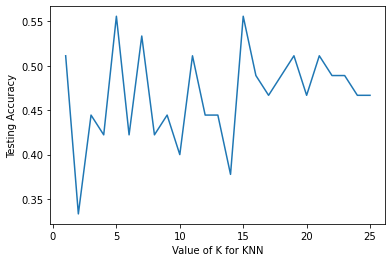

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(k_range, scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [33]:
# Final baseline model
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [34]:
# Show accuracy on test set
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.5555555555555556


In [35]:
sentiment_df.drop(['home','away','week'], inplace=True, axis=1)

In [36]:
sentiment_df.head()

,home_pass,away_pass,home_rush,away_rush,home_points,away_points,home_turnover,away_turnover,home_win,home_sentiment,away_sentiment
0,184.8,136.2,144.9,123.1,21.3,15.2,-0.2,0.3,1,2.351744,1.137602
1,192.5,257.4,118.3,111.6,13.3,23.8,-0.1,0.5,0,1.305769,1.206897
2,293.9,262.6,94.7,112.9,24.8,23.1,0.7,0.3,0,0.543384,1.131638
3,346.7,235.8,129.5,100.9,34.7,18.0,-0.4,-0.9,0,1.155450,1.104220
4,247.6,276.6,131.9,116.5,22.4,25.4,-0.3,-0.4,0,1.012127,1.651613


In [37]:
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(sentiment_df), columns=sentiment_df.columns)

df_scaled.shape

(223, 11)

In [38]:
home_win_df = df_scaled.pop('home_win')

In [39]:
print(home_win_df.shape)
print(df_scaled.shape)

(223,)
(223, 10)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled, home_win_df, test_size=0.2, random_state=4)

In [41]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(178, 10) (45, 10) (178,) (45,)


In [42]:
k_range = range(1,26)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test, y_pred)
    scores_list.append(metrics.accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

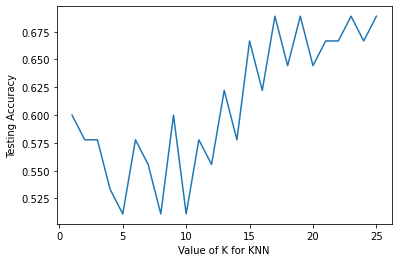

In [43]:
plt.plot(k_range, scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [44]:
# Final baseline model
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=17)

In [45]:
# Show accuracy on test set
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6888888888888889
